# Final Project Report

* Class: DS 5100
* Student Name: Robert Clay Harris
* Student Net ID: jbm2rt
* This URL: https://github.com/robertclayh/monte_carlo/blob/main/project_info/DS51200_FinalProjectTemplate.ipynb

# Instructions

Follow the instructions in the Final Project instructions notebook and put evidence of your work in this notebook.

Total points for each subsection under **Deliverables** and **Scenarios** are given in parentheses.

Breakdowns of points within subsections are specified within subsection instructions as bulleted lists.

This project is worth **50 points**.

# Deliverables

## The Monte Carlo Module (10)

- URL included, appropriately named (1).
- Includes all three specified classes (3).
- Includes at least all 12 specified methods (6; .5 each).

Put the URL to your GitHub repo here.

Repo URL: https://github.com/robertclayh/monte_carlo/tree/main

Paste a copy of your module here.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

### monte_carlo.py

```python
import numpy as np
import pandas as pd
from itertools import combinations_with_replacement, permutations

class Die:
    """
    Represents a single die with customizable faces and weights.
    
    A die can be initialized with a set of faces, each having a default 
    weight of 1.0. Users can modify the weights and roll the die to generate 
    random outcomes based on these weights.
    """
    def __init__(self, faces: np.ndarray):
        """
        Initializes the Die object with faces and equal weights.
        
        Parameters:
        faces (np.ndarray): A NumPy array of unique face values (strings or numbers).
        
        Raises:
        TypeError: If `faces` is not a NumPy array.
        ValueError: If the values in `faces` are not unique.
        """
        if not isinstance(faces, np.ndarray):
            raise TypeError("Faces must be a NumPy array.")
        if len(faces) != len(set(faces)):
            raise ValueError("Faces must contain unique values.")
        
        self._df = pd.DataFrame({
            'face': faces,
            'weight': np.ones(len(faces))
        }).set_index('face')

    def change_weight(self, face, new_weight):
        """
        Changes the weight of a specified face.
        
        Parameters:
        face: The face value whose weight is to be changed.
        new_weight: The new weight to be assigned to the face.
        
        Raises:
        IndexError: If the face value is not found in the die faces.
        TypeError: If the new weight is not a non-negative number.
        """
        if face not in self._df.index:
            raise IndexError("Face value not found in die faces.")
        if not isinstance(new_weight, (int, float)) or new_weight < 0:
            raise TypeError("Weight must be a non-negative number.")
        
        self._df.at[face, 'weight'] = new_weight

    def roll(self, num_rolls=1):
        """
        Rolls the die one or more times.
        
        Parameters:
        num_rolls (int): The number of times to roll the die. Defaults to 1.
        
        Returns:
        list: A list of outcomes from the rolls.
        """
        return self._df.sample(n=num_rolls, weights='weight', replace=True).index.tolist()

    def show(self):
        """
        Shows the current state of the die.
        
        Returns:
        pd.DataFrame: A copy of the die's faces and weights.
        """
        return self._df.copy()
    
class Game:
    """
    Represents a game consisting of rolling one or more similar dice (Die objects) one or more times.
    
    Each die in a given game has the same number of sides and associated faces, but each die object may have its own weights.
    """
    def __init__(self, dice: list):
        """
        Initializes the Game object with a list of Die objects.
        
        Parameters:
        dice (list): A list of Die objects.
        
        Raises:
        TypeError: If the list does not contain Die objects.
        """
        if not all(hasattr(die, 'roll') for die in dice):
            raise TypeError("All items in the list must be Die objects.")
        
        self.dice = dice
        self._play_results = None

    def play(self, n_rolls: int):
        """
        Rolls all dice in the game for a specified number of times.
        
        Parameters:
        n_rolls (int): The number of times to roll the dice.
        
        Saves:
        A private data frame with the results of the rolls in wide format.
        """
        if n_rolls <= 0:
            raise ValueError("Number of rolls must be a positive integer.")
        
        # Roll each die and collect results
        results = {die_idx: die.roll(n_rolls) for die_idx, die in enumerate(self.dice)}
        
        # Create DataFrame in wide format
        self._play_results = pd.DataFrame(results)
        self._play_results.index.name = 'Roll'

    def show(self, form='wide'):
        """
        Shows the results of the most recent play.
        
        Parameters:
        form (str): The format of the returned data frame, either 'wide' or 'narrow'. Defaults to 'wide'.
        
        Returns:
        pd.DataFrame: A copy of the play results in the specified format.
        
        Raises:
        ValueError: If the form parameter is not 'wide' or 'narrow'.
        """
        if self._play_results is None:
            raise ValueError("No play results to show. Please play the game first.")
        
        if form == 'wide':
            return self._play_results.copy()
        elif form == 'narrow':
            return self._play_results.stack().to_frame('Outcome').rename_axis(index=['Roll', 'Die'])
        else:
            raise ValueError("Invalid form. Please choose 'wide' or 'narrow'.")
        
class Analyzer:
    """
    An Analyzer object takes the results of a single game and computes various descriptive statistical properties about it.
    """
    def __init__(self, game):
        """
        Initializes the Analyzer object with a Game object.
        
        Parameters:
        game (Game): A Game object.
        
        Raises:
        ValueError: If the input is not a Game object.
        """
        if not hasattr(game, 'show'):
            raise ValueError("The input must be a Game object.")
        
        self.game = game
        self.results = game.show('wide')

    def jackpot(self):
        """
        Counts how many jackpots occurred in the game.
        
        Returns:
        int: The number of jackpots.
        """
        return int((self.results.nunique(axis=1) == 1).sum())

    def face_counts_per_roll(self):
        """
        Computes the count of each face value per roll.
        
        Returns:
        pd.DataFrame: A DataFrame with roll numbers as rows, face values as columns, and counts as values.
        """
        return self.results.apply(pd.Series.value_counts, axis=1).fillna(0).astype(int)

    def combo_count(self):
        """
        Computes the distinct combinations of faces rolled, along with their counts.
        
        Combinations are order-independent and may contain repetitions.
        
        Returns:
        pd.DataFrame: A DataFrame with a MultiIndex of distinct combinations and a column for the associated counts.
        """
        combos = self.results.apply(lambda row: tuple(sorted(row)), axis=1)
        combo_counts = combos.value_counts().reset_index()
        combo_counts.columns = ['Combination', 'Count']
        combo_counts.set_index('Combination', inplace=True)
        return combo_counts

    def permutation_count(self):
        """
        Computes the distinct permutations of faces rolled, along with their counts.
        
        Permutations are order-dependent and may contain repetitions.
        
        Returns:
        pd.DataFrame: A DataFrame with a MultiIndex of distinct permutations and a column for the associated counts.
        """
        perms = self.results.apply(lambda row: tuple(row), axis=1)
        perm_counts = perms.value_counts().reset_index()
        perm_counts.columns = ['Permutation', 'Count']
        perm_counts.set_index('Permutation', inplace=True)
        return perm_counts
```

## Unitest Module (2)

Paste a copy of your test module below.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

- All methods have at least one test method (1).
- Each method employs one of Unittest's Assert methods (1).

### test_monte_carlo.py

```python
import unittest
import numpy as np
import pandas as pd
from monte_carlo import Die, Game, Analyzer

class TestDie(unittest.TestCase):
    def setUp(self):
        self.faces = np.array([1, 2, 3, 4, 5, 6])
        self.die = Die(self.faces)

    def test_init(self):
        self.assertIsInstance(self.die._df, pd.DataFrame)

    def test_change_weight(self):
        self.die.change_weight(1, 2.0)
        self.assertEqual(self.die._df.loc[1, 'weight'], 2.0)

    def test_roll(self):
        result = self.die.roll(10)
        self.assertEqual(len(result), 10)

    def test_show(self):
        df = self.die.show()
        self.assertIsInstance(df, pd.DataFrame)

class TestGame(unittest.TestCase):
    def setUp(self):
        faces = np.array([1, 2, 3, 4, 5, 6])
        self.dice = [Die(faces), Die(faces)]
        self.game = Game(self.dice)

    def test_init(self):
        self.assertIsInstance(self.game.dice, list)

    def test_play(self):
        self.game.play(10)
        self.assertIsInstance(self.game._play_results, pd.DataFrame)
        self.assertEqual(len(self.game._play_results), 10)

    def test_show(self):
        self.game.play(10)
        df_wide = self.game.show('wide')
        df_narrow = self.game.show('narrow')
        self.assertIsInstance(df_wide, pd.DataFrame)
        self.assertIsInstance(df_narrow, pd.DataFrame)
        self.assertEqual(df_narrow.index.names, ['Roll', 'Die'])

class TestAnalyzer(unittest.TestCase):
    def setUp(self):
        faces = np.array([1, 2, 3, 4, 5, 6])
        dice = [Die(faces), Die(faces)]
        game = Game(dice)
        game.play(10)
        self.analyzer = Analyzer(game)

    def test_init(self):
        self.assertIsInstance(self.analyzer.results, pd.DataFrame)

    def test_jackpot(self):
        jackpots = self.analyzer.jackpot()
        self.assertIsInstance(jackpots, int)

    def test_face_counts_per_roll(self):
        face_counts = self.analyzer.face_counts_per_roll()
        self.assertIsInstance(face_counts, pd.DataFrame)

    def test_combo_count(self):
        combo_counts = self.analyzer.combo_count()
        self.assertIsInstance(combo_counts, pd.DataFrame)

    def test_permutation_count(self):
        perm_counts = self.analyzer.permutation_count()
        self.assertIsInstance(perm_counts, pd.DataFrame)

if __name__ == '__main__':
    unittest.main()
```

## Unittest Results (3)

Put a copy of the results of running your tests from the command line here.

Again, paste as text using triple backticks.

- All 12 specified methods return OK (3; .25 each).

```bash
python3 -m unittest test_monte_carlo.py
............
----------------------------------------------------------------------
Ran 12 tests in 0.008s

OK
```

## Import (1)

Import your module here. This import should refer to the code in your package directory.

- Module successuflly imported (1).

In [1]:
import monte_carlo

## Help Docs (4)

Show your docstring documentation by applying `help()` to your imported module.

- All methods have a docstring (3; .25 each).
- All classes have a docstring (1; .33 each).

In [2]:
help(monte_carlo)

Help on module monte_carlo:

NAME
    monte_carlo

CLASSES
    builtins.object
        Analyzer
        Die
        Game

    class Analyzer(builtins.object)
     |  Analyzer(game)
     |
     |  An Analyzer object takes the results of a single game and computes various descriptive statistical properties about it.
     |
     |  Methods defined here:
     |
     |  __init__(self, game)
     |      Initializes the Analyzer object with a Game object.
     |
     |      Parameters:
     |      game (Game): A Game object.
     |
     |      Raises:
     |      ValueError: If the input is not a Game object.
     |
     |  combo_count(self)
     |      Computes the distinct combinations of faces rolled, along with their counts.
     |
     |      Combinations are order-independent and may contain repetitions.
     |
     |      Returns:
     |      pd.DataFrame: A DataFrame with a MultiIndex of distinct combinations and a column for the associated counts.
     |
     |  face_counts_per_roll(

## `README.md` File (3)

Provide link to the README.md file of your project's repo.

- Metadata section or info present (1).
- Synopsis section showing how each class is called (1). (All must be included.)
- API section listing all classes and methods (1). (All must be included.)

URL: https://github.com/robertclayh/monte_carlo/blob/main/README.md

## Successful installation (2)

Put a screenshot or paste a copy of a terminal session where you successfully install your module with pip.

If pasting text, use a preformatted text block to show the results.

- Installed with `pip` (1).
- Successfully installed message appears (1).

```bash
pip install .
Processing /Users/queclay/Documents/MSDS/programming/monte_carlo
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Requirement already satisfied: numpy in /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-p
ackages (from monte_carlo==0.1) (1.26.4)                                                                        Requirement already satisfied: pandas in /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-
packages (from monte_carlo==0.1) (2.2.2)                                                                        Requirement already satisfied: python-dateutil>=2.8.2 in /Library/Frameworks/Python.framework/Versions/3.12/lib/
python3.12/site-packages (from pandas->monte_carlo==0.1) (2.9.0.post0)                                          Requirement already satisfied: pytz>=2020.1 in /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12
/site-packages (from pandas->monte_carlo==0.1) (2024.1)                                                         Requirement already satisfied: tzdata>=2022.7 in /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.
12/site-packages (from pandas->monte_carlo==0.1) (2024.1)                                                       Requirement already satisfied: six>=1.5 in /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/sit
e-packages (from python-dateutil>=2.8.2->pandas->monte_carlo==0.1) (1.16.0)                                     Building wheels for collected packages: monte_carlo
  Building wheel for monte_carlo (pyproject.toml) ... done
  Created wheel for monte_carlo: filename=monte_carlo-0.1-py3-none-any.whl size=6625 sha256=9c010fec21302c40a93d
52b57bcc5afa55d050eb5e0170473c5764e48346d785                                                                      Stored in directory: /private/var/folders/fn/36dz4z514cd0cmgsz1j3_f340000gn/T/pip-ephem-wheel-cache-bnrmjh17/w
heels/c1/de/e5/94fb9c57af5856cd3d82498699ba02b5550ae5fa2f0c370f3c                                               Successfully built monte_carlo
Installing collected packages: monte_carlo
Successfully installed monte_carlo-0.1
```

# Scenarios

Use code blocks to perform the tasks for each scenario.

Be sure the outputs are visible before submitting.

## Scenario 1: A 2-headed Coin (9)

Task 1. Create a fair coin (with faces $H$ and $T$) and one unfair coin in which one of the faces has a weight of $5$ and the others $1$.

- Fair coin created (1).
- Unfair coin created with weight as specified (1).

In [11]:
from monte_carlo import Die
import numpy as np

# Create a fair coin
fair_coin_faces = np.array(['H', 'T'])
fair_coin = Die(fair_coin_faces)

# Create an unfair coin
unfair_coin_faces = np.array(['H', 'T'])
unfair_coin = Die(unfair_coin_faces)
unfair_coin.change_weight('H', 5)

Task 2. Play a game of $1000$ flips with two fair dice.

- Play method called correclty and without error (1).

In [14]:
from monte_carlo import Game

# Create a game with two fair coins
fair_game = Game([fair_coin, fair_coin])

# Play the game with 1000 flips
fair_game.play(1000)

Task 3. Play another game (using a new Game object) of $1000$ flips, this time using two unfair dice and one fair die. For the second unfair die, you can use the same die object twice in the list of dice you pass to the Game object.

- New game object created (1).
- Play method called correclty and without error (1).

In [15]:
# Create a new game with two unfair coins and one fair coin
unfair_game = Game([unfair_coin, unfair_coin, fair_coin])

# Play the game with 1000 flips
unfair_game.play(1000)

Task 4. For each game, use an Analyzer object to determine the raw frequency of jackpots — i.e. getting either all $H$s or all $T$s.

- Analyzer objecs instantiated for both games (1).
- Raw frequencies reported for both (1).

In [16]:
from monte_carlo import Analyzer

# Instantiate Analyzer objects for both games
fair_game_analyzer = Analyzer(fair_game)
unfair_game_analyzer = Analyzer(unfair_game)

# Determine the raw frequency of jackpots for both games
fair_game_jackpots = fair_game_analyzer.jackpot()
unfair_game_jackpots = unfair_game_analyzer.jackpot()

# Print the raw frequencies
print(f"Raw frequency of jackpots in fair game: {fair_game_jackpots}")
print(f"Raw frequency of jackpots in unfair game: {unfair_game_jackpots}")

Raw frequency of jackpots in fair game: 523
Raw frequency of jackpots in unfair game: 389


Task 5. For each analyzer, compute relative frequency as the number of jackpots over the total number of rolls.

- Both relative frequencies computed (1).

In [17]:
# Compute relative frequency of jackpots for both games
fair_game_relative_frequency = fair_game_jackpots / 1000
unfair_game_relative_frequency = unfair_game_jackpots / 1000

# Print the relative frequencies
print(f"Relative frequency of jackpots in fair game: {fair_game_relative_frequency}")
print(f"Relative frequency of jackpots in unfair game: {unfair_game_relative_frequency}")

Relative frequency of jackpots in fair game: 0.523
Relative frequency of jackpots in unfair game: 0.389


Task 6. Show your results, comparing the two relative frequencies, in a simple bar chart.

- Bar chart plotted and correct (1).

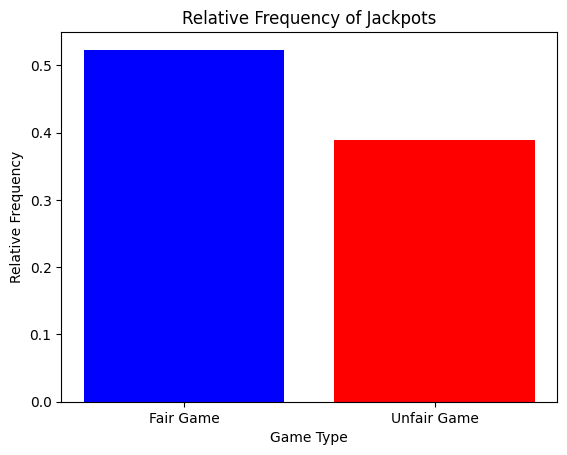

In [18]:
import matplotlib.pyplot as plt

# Data for plotting
labels = ['Fair Game', 'Unfair Game']
relative_frequencies = [fair_game_relative_frequency, unfair_game_relative_frequency]

# Create the bar chart
plt.bar(labels, relative_frequencies, color=['blue', 'red'])

# Add title and labels
plt.title('Relative Frequency of Jackpots')
plt.xlabel('Game Type')
plt.ylabel('Relative Frequency')

# Show the plot
plt.show()

## Scenario 2: A 6-sided Die (9)

Task 1. Create three dice, each with six sides having the faces 1 through 6.

- Three die objects created (1).

In [19]:
# Create three dice, each with six sides having the faces 1 through 6
faces = np.array([1, 2, 3, 4, 5, 6])
die1 = Die(faces)
die2 = Die(faces)
die3 = Die(faces)

Task 2. Convert one of the dice to an unfair one by weighting the face $6$ five times more than the other weights (i.e. it has weight of 5 and the others a weight of 1 each).

- Unfair die created with proper call to weight change method (1).

In [20]:
# Convert die1 to an unfair die by weighting the face 6 five times more than the other weights
die1.change_weight(6, 5)

Task 3. Convert another of the dice to be unfair by weighting the face $1$ five times more than the others.

- Unfair die created with proper call to weight change method (1).

In [21]:
# Convert die2 to an unfair die by weighting the face 1 five times more than the other weights
die2.change_weight(1, 5)

Task 4. Play a game of $10000$ rolls with $5$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [22]:
# Create a game with five fair dice
fair_dice_game = Game([die3, die3, die3, die3, die3])

# Play the game with 10000 rolls
fair_dice_game.play(10000)

Task 5. Play another game of $10000$ rolls, this time with $2$ unfair dice, one as defined in steps #2 and #3 respectively, and $3$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [23]:
# Create a game with two unfair dice (die1 and die2) and three fair dice (die3)
mixed_dice_game = Game([die1, die2, die3, die3, die3])

# Play the game with 10000 rolls
mixed_dice_game.play(10000)

Task 6. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

- Jackpot methods called (1).
- Graph produced (1).

Relative frequency of jackpots in fair dice game: 0.0007
Relative frequency of jackpots in mixed dice game: 0.0003


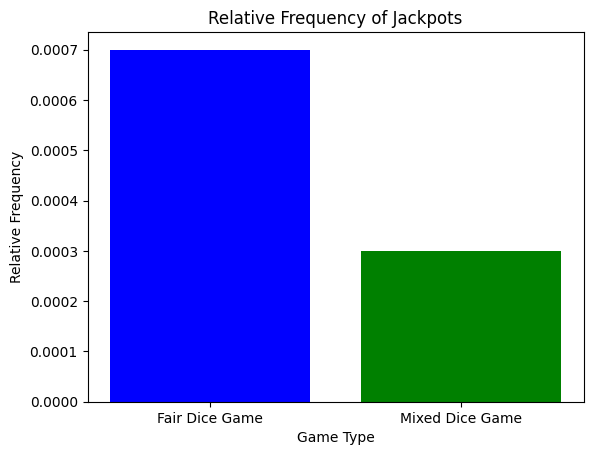

In [24]:
# Instantiate Analyzer objects for both games
fair_dice_analyzer = Analyzer(fair_dice_game)
mixed_dice_analyzer = Analyzer(mixed_dice_game)

# Determine the raw frequency of jackpots for both games
fair_dice_jackpots = fair_dice_analyzer.jackpot()
mixed_dice_jackpots = mixed_dice_analyzer.jackpot()

# Compute relative frequency of jackpots for both games
fair_dice_relative_frequency = fair_dice_jackpots / 10000
mixed_dice_relative_frequency = mixed_dice_jackpots / 10000

# Print the relative frequencies
print(f"Relative frequency of jackpots in fair dice game: {fair_dice_relative_frequency}")
print(f"Relative frequency of jackpots in mixed dice game: {mixed_dice_relative_frequency}")

# Data for plotting
labels = ['Fair Dice Game', 'Mixed Dice Game']
relative_frequencies = [fair_dice_relative_frequency, mixed_dice_relative_frequency]

# Create the bar chart
plt.bar(labels, relative_frequencies, color=['blue', 'green'])

# Add title and labels
plt.title('Relative Frequency of Jackpots')
plt.xlabel('Game Type')
plt.ylabel('Relative Frequency')

# Show the plot
plt.show()

## Scenario 3: Letters of the Alphabet (7)

Task 1. Create a "die" of letters from $A$ to $Z$ with weights based on their frequency of usage as found in the data file `english_letters.txt`. Use the frequencies (i.e. raw counts) as weights.

- Die correctly instantiated with source file data (1).
- Weights properly applied using weight setting method (1).

In [12]:
# Read the letter frequencies from the file
letter_frequencies = {}
with open('english_letters.txt', 'r') as file:
    for line in file:
        letter, frequency = line.split()
        letter_frequencies[letter] = int(frequency)

# Create a die with letters A to Z
letters = np.array(list(letter_frequencies.keys()))
letter_die = Die(letters)

# Apply the weights to the die
for letter, weight in letter_frequencies.items():
    letter_die.change_weight(letter, weight)

Task 2. Play a game involving $4$ of these dice with $1000$ rolls.

- Game play method properly called (1).

In [15]:
# Create a game with four letter dice
letter_game = Game([letter_die, letter_die, letter_die, letter_die])

# Play the game with 1000 rolls
letter_game.play(1000)

Task 3. Determine how many permutations in your results are actual English words, based on the vocabulary found in `scrabble_words.txt`.

- Use permutation method (1).
- Get count as difference between permutations and vocabulary (1).

In [19]:
# Generate permutations of the results from the game
letter_analyzer = Analyzer(letter_game)
permutations = letter_analyzer.permutation_count().index

# Load the vocabulary from scrabble_words.txt
with open('scrabble_words.txt', 'r') as file:
    vocabulary = set(word.strip().upper() for word in file)

# Count how many of the permutations are actual English words
actual_words_count = sum(1 for perm in permutations if ''.join(perm) in vocabulary)

# Print the count of actual English words
print(f"Number of actual English words: {actual_words_count}")

Number of actual English words: 56


Task 4. Repeat steps #2 and #3, this time with $5$ dice. How many actual words does this produce? Which produces more?

- Successfully repreats steps (1).
- Identifies parameter with most found words (1).

In [20]:
# Create a game with five letter dice
letter_game_5_dice = Game([letter_die, letter_die, letter_die, letter_die, letter_die])

# Play the game with 1000 rolls
letter_game_5_dice.play(1000)

# Generate permutations of the results from the game
letter_analyzer_5_dice = Analyzer(letter_game_5_dice)
permutations_5_dice = letter_analyzer_5_dice.permutation_count().index

# Count how many of the permutations are actual English words
actual_words_count_5_dice = sum(1 for perm in permutations_5_dice if ''.join(perm) in vocabulary)

# Print the count of actual English words
print(f"Number of actual English words with 4 dice: {actual_words_count}")
print(f"Number of actual English words with 5 dice: {actual_words_count_5_dice}")

# Identify which produces more words
if actual_words_count_5_dice > actual_words_count:
    print("5 dice produce more actual English words.")
else:
    print("4 dice produce more actual English words.")

Number of actual English words with 4 dice: 56
Number of actual English words with 5 dice: 5
4 dice produce more actual English words.
